In [17]:
using DataFrames, Plots, Statistics, JSON, Clp
#plotlyjs() uncomment for interactive plots
include(joinpath(dirname(pwd()),"src/TuLiPa.jl")); # using Dates, JuMP, HiGHS, CSV, Clustering;

# Demo 2 - Deterministic power market with detailed data

Demo 1 gave an introduction to the TuLiPa framework and how a dataset can be built, and how a problem can be built, updated, solved and results queried. Demo 2 will show that TuLiPa also can be used on a more complete dataset, and with more complex model objects.

## Overview of the document:
### 1 - European power market problem
1.1-1.3 Build, solve and look at solution 

1.4 Look at time usage with different types of horizons. 

1.5 Compare time usage between JuMP_Prob and HiGHS_Prob.

1.6 Compare time usage with different solvers.

1.7 Generate price-series for hydropower scheduling

# 1. Power market problem with European dataset

This is a simplified version of the dataset NVE uses for its long-term power market analyses (for example https://www.nve.no/energi/analyser-og-statistikk/langsiktig-kraftmarkedsanalyse/). The dataset consist of:
- Detailed thermal units, aggregated hydro (Res, RoR, PHS), inelastic wind and solar, demands (inelastic with rationing price), storages (hydro and battery), transmission (ATC) and price areas (endogenous and exogenous). 
- Levels in 2021, 2025, 2030, 2040 and 2050 (e.g. commodity price levels, installed production/transmission/storage capacities etc.)
- Profiles (e.g. availability profiles for transmission or production units, commodity price profiles, weather scenario profiles 1981-2010 for demand, solar, wind and inflow etc.)

We cannot publish the full dataset, but many of the profiles for wind, solar, hydro and demand can be downloaded from https://www.nve.no/energi/analyser-og-statistikk/vaerdatasett-for-kraftsystemmodellene/.

#### NB! 
- In Demo 2 we use the model year 2025. This scenario was made a couple of years ago and results should be considered outdated. A lot has happened in the power market since then. In addition the dataset is very simplified.

## 1.1 Functions that adds or removes model objects to complete the dataset

In [20]:
# The hydropower storages in the dataset needs boundary conditions for the state variables
function addStartEqualStopAllStorages!(modelobjects)
    for obj in values(modelobjects)
        if obj isa BaseStorage
            trait = StartEqualStop(obj)
            modelobjects[getid(trait)] = trait
        end
    end
end

# Power balances needs slack variable for when the inelastic supply (wind, solar, RoR) is higher than the inelastic demand
function addPowerUpperSlack!(modelobjects) # add after object manipulation
    for obj in values(modelobjects)
        if obj isa BaseBalance
            if getid(getcommodity(obj)) == Id("Commodity", "Power")
                balancename = getinstancename(getid(obj))
                
                varname = "SlackVar_" * balancename
                varkey = Id(FLOW_CONCEPT, varname)
                var = BaseFlow(varkey)
                
                sethorizon!(var, gethorizon(obj))
                setlb!(var, LowerZeroCapacity())
                
                arrowname = "SlackArrow_" * balancename
                arrowkey = Id(ARROW_CONCEPT, arrowname) 
                arrow = BaseArrow(arrowkey, obj, BaseConversion(PlusOneParam()), 0)
                addarrow!(var, arrow)
                
                modelobjects[varkey] = var
            end
        end 
    end
end

# Remove elements that are not compatible with certain Horizons.
function remove_startupcosts!(modelobjects)
    for (id,obj) in modelobjects
        if obj isa StartUpCost
            delete!(modelobjects, id)
        end
    end
end
function remove_transmissionramping!(modelobjects::Dict)
    for (id,obj) in modelobjects
        if obj isa TransmissionRamping
            delete!(modelobjects, id)
        end
    end
end

remove_transmissionramping! (generic function with 1 method)

## 1.2 Function that builds, updates and solves the problem, and plot the results

The function runs several scenarios and plot prices, production, demand and hydro storage for each scenario. The function only plots results for chosen price areas.

Unlike Demo 1, the function now support more types of objects. This includes AdaptiveHorizons (horizon built based on residual load), Horizons with offset, SegmentedArrow (for hydropower plants with PQ-curves), BaseAggSupplyCurve (for aggregated power plants) and ExogenBalance (exogen price areas)

In [21]:
# Make list of scenarios
function getscenarios(dt; years)
    [TwoTime(getisoyearstart(dt), getisoyearstart(yr)) for yr in years]
end

# Run scenarios and plot results from the whole problem
function runscenarios(scenarios, modelobjects)
    runscenarios(scenarios, modelobjects, values(modelobjects))
end

# Run scenarios and plot results from chosen model objects (e.g. only one price area)
function runscenarios(scenarios, modelobjects, resultobjects)
    numperiods_powerhorizon = getnumperiods(power_horizon)
    numperiods_hydrohorizon = getnumperiods(hydro_horizon)
    
    # We use the datatime for plotting results
    dt = getdatatime(scenarios[1])

    # Time vector for power_horizon, can be Adaptive
    if power_horizon isa AdaptiveHorizon
        numperiods_data = Int(getduration(hydro_horizon)/power_horizon.unit_duration)
        x1 = [dt + power_horizon.unit_duration*(t-1) for t in 1:numperiods_data]
    else
        numperiods_data = numperiods_powerhorizon
        x1 = [dt + getstartduration(power_horizon, t) for t in 1:numperiods_powerhorizon]
    end

    # Time vector for hydro_horizon
    x2 = [dt + getstartduration(hydro_horizon, t) for t in 1:numperiods_hydrohorizon]
    
    # Horizons can have offset, assumes its the same for both horizons
    if hasoffset(hydro_horizon)
        x1 = x1 .+ getduration(getoffset(power_horizon))
        x2 = x2 .+ getduration(getoffset(hydro_horizon))
    end
    
    # Problem can be a HiGHS_Prob or a JuMP_Prob
#     mymodel = JuMP.Model(HiGHS.Optimizer)
#     set_silent(mymodel)
#     prob = JuMP_Prob(collect(values(modelobjects)), mymodel)

    @time prob = HiGHS_Prob(collect(values(modelobjects)))

    # Order result objects into lists
    powerbalances = []
    rhsterms = []
    plants = []
    plantbalances = []
    plantarrows = Dict()
    demands= []
    demandbalances = []
    demandarrows = Dict()
    hydrostorages = []
    
    for obj in resultobjects # regret using Ids rather than the whole object
        
        # Powerbalances
        if obj isa BaseBalance
            if getinstancename(getid(getcommodity(obj))) == "Power"
                if !isexogen(obj)
                    push!(powerbalances, getid(obj))
                    for rhsterm in getrhsterms(obj)
                        push!(rhsterms,getid(rhsterm))
                    end
                end
            end
        end
        
        # Hydrostorages
        if obj isa BaseStorage
            if getinstancename(getid(getcommodity(getbalance(obj)))) == "Hydro"
                push!(hydrostorages,getid(obj))
            end
        end
        
        # Supply and demands
        if obj isa BaseFlow
            # The type of supply or demand can be found based on the arrows
            arrows = getarrows(obj)
            
            # Simple supplies and demands
            powerarrowbool = [(getid(getcommodity(getbalance(arrow))) == Id("Commodity", "Power")) & !(arrow isa SegmentedArrow) for arrow in arrows]
            powerarrows = arrows[powerarrowbool]
            if sum(powerarrowbool) == 1
                if isingoing(powerarrows[1])
                    push!(plants,getid(obj))
                    push!(plantbalances,getid(getbalance(powerarrows[1])))
                elseif !isingoing(powerarrows[1])
                    push!(demands,getid(obj))
                    push!(demandbalances,getid(getbalance(powerarrows[1])))
                end
            end
            
            # Transmissions
            if sum(powerarrowbool) == 2
                for arrow in arrows
                    balance = getbalance(arrow)
                    if getid(getcommodity(balance)) == Id("Commodity", "Power")
                        if isingoing(arrow) && (balance in resultobjects)
                            push!(plants,getid(obj))
                            push!(plantbalances,getid(balance))
                            if isexogen(balance)
                                plantarrows[getid(obj)] = arrow
                            end
                        elseif !isingoing(arrow) && (balance in resultobjects)
                            push!(demands,getid(obj))
                            push!(demandbalances,getid(balance))
                            if isexogen(balance)
                                demandarrows[getid(obj)] = arrow
                            end
                        end
                    end
                end
            end
            
                        
            # Supplies with SegmentedArrows (hydropower with PQ-kurves)
            pqarrowbool = [arrow isa SegmentedArrow for arrow in arrows]
            pqarrows = arrows[pqarrowbool]
            if sum(pqarrowbool) == 1
                if isingoing(pqarrows[1])
                    push!(plants,getid(obj))
                    push!(plantbalances,getid(getbalance(pqarrows[1])))
                end
            end
        end
        
        # Aggregated supplies (thermal power plants aggregated into one or more equivalent supplies)
        # TODO: Result should be a sum of all clusters, not separated
        if obj isa BaseAggSupplyCurve
            instance = getinstancename(getid(obj))
            concept = getconceptname(getid(obj))
            balance = getbalance(obj)
            for c in 1:getnumclusters(obj)
                newname = string(instance,"_",c)
                push!(plants,Id(concept,newname))
                push!(plantbalances,getid(balance))
            end
        end
    end
    
    # Matrices to store results per time period, scenario and object
    prices = zeros(numperiods_data, length(scenarios), length(powerbalances))
    rhstermvalues = zeros(numperiods_data, length(scenarios), length(rhsterms))
    production = zeros(numperiods_data, length(scenarios), length(plants))
    consumption = zeros(numperiods_data, length(scenarios), length(demands))
    hydrolevels = zeros(numperiods_hydrohorizon, length(scenarios), length(hydrostorages))
    
    # Update and solve scenarios, and collect results
    for (s, t) in enumerate(scenarios)
        @time update!(prob, t)
        
        @time solve!(prob)
        
        println("Objective value in scenario $(s): ", getobjectivevalue(prob))

        # Collect results for power production/demand/transmission in GW
        if power_horizon isa SequentialHorizon
            for j in 1:numperiods_powerhorizon
                
                # Timefactor transform results from GWh to GW/h regardless of horizon period durations
                timefactor = getduration(gettimedelta(power_horizon, j))/Millisecond(3600000)
                
                # For powerbalances collect prices and rhsterms (like inelastic demand, wind, solar and RoR)
                for i in 1:length(powerbalances)
                    prices[j, s, i] = -getcondual(prob, powerbalances[i], j)/1000 # from €/GWh to €/MWh
                    for k in 1:length(rhsterms)
                        if hasrhsterm(prob, powerbalances[i], rhsterms[k], j)
                            rhstermvalues[j, s, k] = getrhsterm(prob, powerbalances[i], rhsterms[k], j)/timefactor
                        end
                    end
                end
                
                # Collect production of all plants
                for i in 1:length(plants) # TODO: Balance and variable can have different horizons
                    concept = getconceptname(plants[i])
                    if concept != AGGSUPPLYCURVE_CONCEPT
                        arrows = getarrows(modelobjects[plants[i]])
                        pqarrowbool = [arrow isa SegmentedArrow for arrow in arrows]
                        pqarrows = arrows[pqarrowbool]                        
                        if sum(pqarrowbool) == 1
                            production[j, s, i] = 0
                            for k in 1:length(getconversions(pqarrows[1]))
                                segmentid = getsegmentid(pqarrows[1], k)
                                production[j, s, i] += getvarvalue(prob, segmentid, j)*abs(getconcoeff(prob, plantbalances[i], segmentid, j, j))/timefactor
                            end
                        else
                            if isexogen(modelobjects[plantbalances[i]])
                                # TODO: Balance and variable can have different horizons
                                arrow = plantarrows[plants[i]]
                                horizon = gethorizon(arrow)
                                conversionparam = _getcontributionparam(arrow)
                                querytime = getstarttime(horizon, j, t)
                                querydelta = gettimedelta(horizon, j)
                                conversionvalue = getparamvalue(conversionparam, querytime, querydelta)
                                production[j, s, i] = getvarvalue(prob, plants[i], j)*conversionvalue/timefactor
                            else
                                production[j, s, i] = getvarvalue(prob, plants[i], j)*abs(getconcoeff(prob, plantbalances[i], plants[i], j, j))/timefactor
                            end
                        end
                    else
                        production[j, s, i] = getvarvalue(prob, plants[i], j)*abs(getconcoeff(prob, plantbalances[i], plants[i], j, j))/timefactor
                    end
                end
                
                # Collect demand of all demands
                for i in 1:length(demands) # TODO: Balance and variable can have different horizons
                    if isexogen(modelobjects[demandbalances[i]])
                        arrow = demandarrows[demands[i]]
                        horizon = gethorizon(arrow)
                        conversionparam = _getcontributionparam(arrow)
                        querytime = getstarttime(horizon, j, t)
                        querydelta = gettimedelta(horizon, j)
                        conversionvalue = getparamvalue(conversionparam, querytime, querydelta)
                        consumption[j, s, i] = getvarvalue(prob, demands[i], j)*conversionvalue/timefactor
                    else
                        consumption[j, s, i] = getvarvalue(prob, demands[i], j)*abs(getconcoeff(prob, demandbalances[i], demands[i], j, j))/timefactor
                    end
                end
            end
        else # if power_horizon isa AdaptiveHorizon it is more complex (also test switching order, could be faster to start with objects and traits?)
            # Non-consecutive time units have been aggregated in the model, and values need to be distributed to the correct time period
            acc = 0
            prev_acc = 0
            for mp in 1:numperiods_hydrohorizon
                for block in 1:power_horizon.num_block
                    j = (mp-1)*power_horizon.num_block + block
                    period = power_horizon.periods[j]
                    timefactor = getduration(period)/Millisecond(3600000)
                    acc += getlength(period)
                    for segment in period.units
                        for unit in segment
                            fineperiod = prev_acc + unit

                            # For powerbalances collect prices and rhsterms (like inelastic demand, wind, solar and RoR)
                            for i in 1:length(powerbalances)
                                prices[fineperiod, s, i] = -getcondual(prob, powerbalances[i], j)/1000
                                for k in 1:length(rhsterms)
                                    if hasrhsterm(prob, powerbalances[i], rhsterms[k], j)
                                        rhstermvalues[fineperiod, s, k] = getrhsterm(prob, powerbalances[i], rhsterms[k], j)/timefactor
                                    end
                                end
                            end

                            # Collect production of all plants
                            for i in 1:length(plants) # TODO: Balance and variable can have different horizons
                                concept = getconceptname(plants[i])
                                if concept != AGGSUPPLYCURVE_CONCEPT
                                    arrows = getarrows(modelobjects[plants[i]])
                                    pqarrowbool = [arrow isa SegmentedArrow for arrow in arrows]
                                    pqarrows = arrows[pqarrowbool]                        
                                    if sum(pqarrowbool) == 1
                                        for k in 1:length(getconversions(pqarrows[1]))
                                            segmentid = getsegmentid(pqarrows[1], k)
                                            production[fineperiod, s, i] += getvarvalue(prob, segmentid, j)*abs(getconcoeff(prob, plantbalances[i], segmentid, j, j))/timefactor
                                        end
                                    else
                                        if isexogen(modelobjects[plantbalances[i]])
                                            # TODO: Balance and variable can have different horizons
                                            arrow = plantarrows[plants[i]]
                                            horizon = gethorizon(arrow)
                                            conversionparam = _getcontributionparam(arrow)
                                            querytime = getstarttime(horizon, j, t)
                                            querydelta = gettimedelta(horizon, j)
                                            conversionvalue = getparamvalue(conversionparam, querytime, querydelta)
                                            production[j, s, i] = getvarvalue(prob, plants[i], j)*conversionvalue/timefactor
                                        else
                                            production[fineperiod, s, i] = getvarvalue(prob, plants[i], j)*abs(getconcoeff(prob, plantbalances[i], plants[i], j, j))/timefactor
                                        end
                                    end
                                else
                                    production[fineperiod, s, i] = getvarvalue(prob, plants[i], j)*abs(getconcoeff(prob, plantbalances[i], plants[i], j, j))/timefactor
                                end
                            end

                            # Collect demand of all demands
                            for i in 1:length(demands) # TODO: Balance and variable can have different horizons
                                if isexogen(modelobjects[demandbalances[i]])
                                    arrow = demandarrows[demands[i]]
                                    horizon = gethorizon(arrow)
                                    conversionparam = _getcontributionparam(arrow)
                                    querytime = getstarttime(horizon, j, t)
                                    querydelta = gettimedelta(horizon, j)
                                    conversionvalue = getparamvalue(conversionparam, querytime, querydelta)
                                    consumption[j, s, i] = getvarvalue(prob, demands[i], j)*conversionvalue/timefactor
                                else
                                    consumption[fineperiod, s, i] = getvarvalue(prob, demands[i], j)*abs(getconcoeff(prob, demandbalances[i], demands[i], j, j))/timefactor
                                end
                            end
                        end
                    end
                end
                prev_acc = acc
            end
        end

        # Collect hydro storage levels
        for j in 1:numperiods_hydrohorizon
            for i in 1:length(hydrostorages)
                hydrolevels[j, s, i] = getvarvalue(prob, hydrostorages[i], j)/1000 # Gm3 TODO: convert to TWh with global energy equivalents of each storage
            end
        end
    end
    
    # Only keep rhsterms that have at least one value (TODO: Do the same for sypply and demands)
    rhstermtotals = dropdims(sum(rhstermvalues,dims=(1,2)),dims=(1,2))
    rhstermsupplyidx = []
    rhstermdemandidx = []
    
    for k in 1:length(rhsterms)
        if rhstermtotals[k] > 0
            push!(rhstermsupplyidx, k)
        elseif rhstermtotals[k] < 0
            push!(rhstermdemandidx, k)
        end
    end
    
    # Put rhsterms together with supplies and demands
    rhstermsupplyvalues = rhstermvalues[:,:,rhstermsupplyidx]
    rhstermdemandvalues = rhstermvalues[:,:,rhstermdemandidx]*-1
    
    rhstermsupplynames = [getinstancename(rhsterm) for rhsterm in rhsterms[rhstermsupplyidx]]
    rhstermdemandnames = [getinstancename(rhsterm) for rhsterm in rhsterms[rhstermdemandidx]]
    
    supplynames = [[getinstancename(plant) for plant in plants];rhstermsupplynames]
    supplyvalues = reshape([vcat(production...);vcat(rhstermsupplyvalues...)],(numperiods_data,length(scenarios),length(supplynames)))

    demandnames = [[getinstancename(demand) for demand in demands];rhstermdemandnames]
    demandvalues = reshape([vcat(consumption...);vcat(rhstermdemandvalues...)],(numperiods_data,length(scenarios),length(demandnames)))

    # Prepare for plotting results
    hydronames = [getinstancename(hydro) for hydro in hydrostorages]
    powerbalancenames = [split(getinstancename(powerbalance), "PowerBalance_")[2] for powerbalance in powerbalances]

    # Plot results for each scenario
    for (s, t) in enumerate(scenarios)
        scenyear = string(getisoyear(getscenariotime(t)))
        datayear = string(getisoyear(getdatatime(t)))
        
        # Plot prices
        display(plot(x1, sum(prices[:,s,:],dims=3), labels=reshape(powerbalancenames,1,length(powerbalancenames)), size=(800,500), title="Prices in " * datayear * " for weather scenario " * scenyear, ylabel="€/MWh"))
        
        # Plot supplies and demands
#         supplychart = areaplot(x1, sum(supplyvalues[:,s,:],dims=3),labels=reshape(supplynames,1,length(supplynames)),title="Supply", ylabel = "GWh/h")
#         demandchart = areaplot(x1, sum(demandvalues[:,s,:],dims=3),labels=reshape(demandnames,1,length(demandnames)),title="Demand", ylabel = "GWh/h")
#         display(plot([supplychart,demandchart]...,layout=(1,2),size=(1600,500)))
        supplychart = areaplot(x1, sum(supplyvalues[:,s,:],dims=(3,2)),title="Supply", ylabel = "GWh/h")
        demandchart = areaplot(x1, sum(demandvalues[:,s,:],dims=(3,2)),title="Demand", ylabel = "GWh/h")
        display(plot([supplychart,demandchart]...,layout=(1,2),size=(900,500)))

        
        # Plot storages (only TWh because of our input data)
        display(areaplot(x2, sum(hydrolevels[:,s,:],dims=3),labels=reshape(hydronames,1,length(hydronames)),size=(800,500),title="Reservoir levels", ylabel = "TWh")) # 
        
        # Plot list of yearly mean production and demand for each supply/demand
        meandemand = dropdims(mean(demandvalues[:,s,:],dims=1),dims=1)
        meanproduction = dropdims(mean(supplyvalues[:,s,:],dims=1),dims=1)
        supplydf = sort(DataFrame(Supplyname = supplynames, Yearly_supply_TWh = meanproduction*8.76),[:Yearly_supply_TWh], rev = true)
        demanddf = sort(DataFrame(Demandname = demandnames, Yearly_demand_TWh = meandemand*8.76),[:Yearly_demand_TWh], rev = true)
        supplydf[!,:ID] = collect(1:length(supplynames))
        demanddf[!,:ID] = collect(1:length(demandnames))
        joineddf = select!(outerjoin(supplydf,demanddf;on=:ID),Not(:ID))
#         show(joineddf,allcols=true, allrows=true)
        
        # Check that total supply equals total demand
        show(combine(joineddf, [:Yearly_supply_TWh, :Yearly_demand_TWh] .=> sum∘skipmissing))
    end
end;

## 1.3 - Assemble dataset and run scenarios

### Read dataelements stored in two JSON-files (structure and timeseries)

In [49]:
sti_themadata = raw""
sti_data_fra_dynmodell = raw""

""

In [36]:
tst = JSON.parsefile(joinpath(sti_themadata, "dataset_thema.json"))
themastructure = getelements(tst) 
tse = JSON.parsefile(joinpath(sti_themadata, "tidsserier_thema.json"))
themaseries = getelements(tse, sti_themadata)

elements = vcat(themaseries,themastructure)
length(elements)

9470

### Alternatively we could combine the European dataset with our detailed hydropower (full watercourses, restrictions, pq-kurves) dataset for Norway and Sweden (see demo 4)
This would increase the problem size a lot, so we could not continue with this dataset without aggregating it somehow. But it gives the user the possibility to aggregate the hydropower however they want. 

NB! We don't continue with this dataset.

In [37]:
tst = JSON.parsefile(joinpath(sti_themadata, "dataset_thema_excl_hydro_nose.json")) # European dataset without aggregated hydro in Norway and Sweden
themastructure = getelements(tst) 
tse = JSON.parsefile(joinpath(sti_themadata, "tidsserier_thema.json"))
themaseries = getelements(tse, sti_themadata)

dse = JSON.parsefile(joinpath(sti_data_fra_dynmodell, "tidsserier_detd.json"))
detdseries = getelements(dse);
dst = JSON.parsefile(joinpath(sti_data_fra_dynmodell, "dataset_detd.json"))
detdstructure = getelements(dst);

elements1 = vcat(themaseries,themastructure,detdseries,detdstructure)
length(elements1)

39974

### Runsettings to complete the dataset

In [38]:
# Select the weather scenarios 1981-2010
# Used by RotatingTimeVector to reduce the amount of data
scenarioyearstart = 1981
scenarioyearstop = 2011
push!(elements, getelement(TIMEPERIOD_CONCEPT, "ScenarioTimePeriod", "ScenarioTimePeriod", 
        ("Start", getisoyearstart(scenarioyearstart)), ("Stop", getisoyearstart(scenarioyearstop))))

# We choose the horizon (time-resolution) of the commodities. We set the duration of the horizons to 1 year
# Having different horizons for different commodities gives flexibility. Here we use it to have more details in the
# variables connected to power, than variables connected to hydro. We also need the storage

# The hydro horizon is sequential with a weekly time-resolution. 
hydro_horizon = SequentialHorizon(13*4, Hour(168))

# The power horizon is an AdaptiveHorizon which is dynamically built based on the residual load (see src/horizons.jl for description)
# There are 7 clusters, which mean that the power horizon will have 7 periods inside each hydro horizon period
# For each hydro horizon period, units (hours) are grouped together with units that have a similar residual load, into 7 clusters
rhsdata = DynamicRHSAHData("Power") # alternative StaticRHSAHData("Power", 2021, scenarioyearstart, scenarioyearstop)
# rhsdata = StaticRHSAHData("Power", 2025, scenarioyearstart, scenarioyearstop)
method = KMeansAHMethod() # alternative PercentilesAHMethod()
clusters = 7
unit_duration = Hour(3)
power_horizon = AdaptiveHorizon(clusters, unit_duration, rhsdata, method, 13*4, Hour(168)) #, offset=MsTimeDelta(Week(1)))
# power_horizon = SequentialHorizon(13*4*5, Hour(168))

# Insert horizons into commodities. E.g. all batteries will have the power horizon, since they interact with the power market
function set_horizon!(elements, commodity, horizon)
    # If element already exist, replace horizon with new
    for element in elements
        if element.typename == "BaseCommodity"
            if element.instancename == commodity
                element.value[HORIZON_CONCEPT] = horizon
                return
            end
        end
    end
    
    # Else, add commodity to element list
    push!(elements, getelement(COMMODITY_CONCEPT, "BaseCommodity", commodity, 
        (HORIZON_CONCEPT, horizon)))
end

# The power horizon will be assigned to everything contributing to the power market, or batteries
set_horizon!(elements, "Power", power_horizon)
set_horizon!(elements, "Battery", power_horizon)

# The hydro horizon will be assigned to storages, bypasses and spill variables of hydropower plants (not release because it contributes to the power market and therefore needs to have power_horizon as its horizon)
set_horizon!(elements, "Hydro", hydro_horizon);

### Convert DataElements into modelobjects

In [39]:
modelobjects = getmodelobjects(elements);
length(modelobjects)

1444

### Simplify market description and add boundary conditions
When the model objects have been created we can manipulate them however we want. In this example we simplify the problem by aggregating areas and power plants, and removing short term storage systems and start-up costs. We also add boundary conditions to storages.

In [40]:
function simplify!(modelobjects)
    # Aggregate price areas and add power balance slack variables
    # For the new area FRACHE, the transmission line FRA-CHE is transformed into a demand based on the loss and utilization of the line
    aggzoneareadict = Dict("NLDBEL" => ["NLD","HUB_NLD","BEL","HUB_BEL"],
    "FRACHE" => ["FRA","CHE"],
    "AUTCZE" => ["AUT","CZE"],
    "BAL" => ["LTU","LVA","EST","HUB_OST"],
    "DMK" => ["DK1","HUB_DK1","DK2","HUB_DK2"],
    "NOS" => ["NO1","NO2","NO5"],
    "NON" => ["NO3","NO4"],
    "SEN" => ["SE1","SE2"],
    "SES" => ["SE3","SE4"])
    aggzonedict = Dict()
    for (k,v) in aggzoneareadict
        aggzonedict[Id(BALANCE_CONCEPT,"PowerBalance_" * k)] = [modelobjects[Id(BALANCE_CONCEPT,"PowerBalance_" * vv)] for vv in v]
    end

    aggzone!(modelobjects, aggzonedict)
    
    # Add slack variable for excessive renewable power
    addPowerUpperSlack!(modelobjects)

    # Start-up-costs are not compatible with aggregatesupplycurve! or AdaptiveHorizon
    remove_startupcosts!(modelobjects)
    
    # TransmissionRamping not compatible with AdaptiveHorizon
    remove_transmissionramping!(modelobjects)

    # Aggregate all simple plants (only connected to power market, mostly thermal) for each area into 4 equivalent plants
    aggregatesupplycurve!(modelobjects, 4)

    # Short-term storage systems are only needed when the horizon is fine 
    removestoragesystems!(modelobjects, Hour(10))

    # Only calculate AdaptiveHorizon based on residual loads in these areas
    residualloadareas!(modelobjects, ["DEU","NLDBEL","POL","GBR","BAL"])

    # Storages have state-dependant variables that need a boundary conditions
    # We set the starting storage to be equal to the ending storage, x[0] = x[T] (for horizon where t in 1:T)
    addStartEqualStopAllStorages!(modelobjects)
end

simplify!(modelobjects);

### Solve a problem and plot results
Due to AdaptiveHorizon we get hourly price volatility even though the LP-problem only has seven periods per week. This leads to seven price levels per week, where hours with similar residual loads will have the same price, because they where grouped together into one period.

  0.151094 seconds (784.13 k allocations: 74.089 MiB)
  0.482365 seconds (4.33 M allocations: 147.513 MiB)
  0.990140 seconds
Objective value in scenario 1: 536997.2748790097


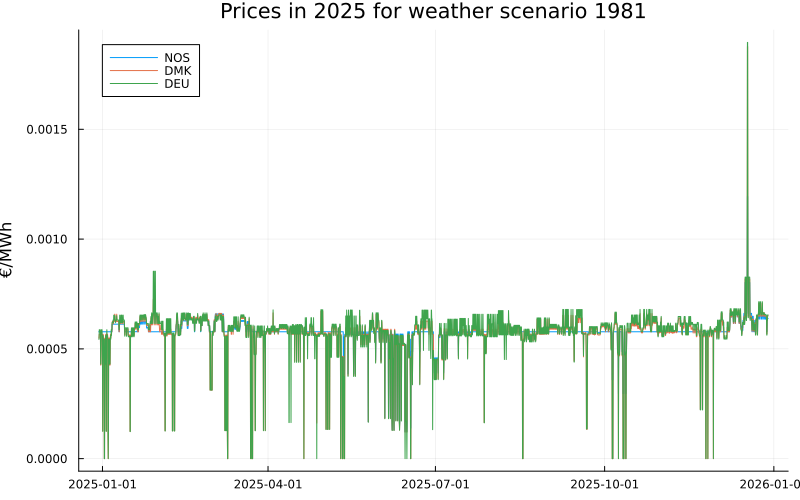

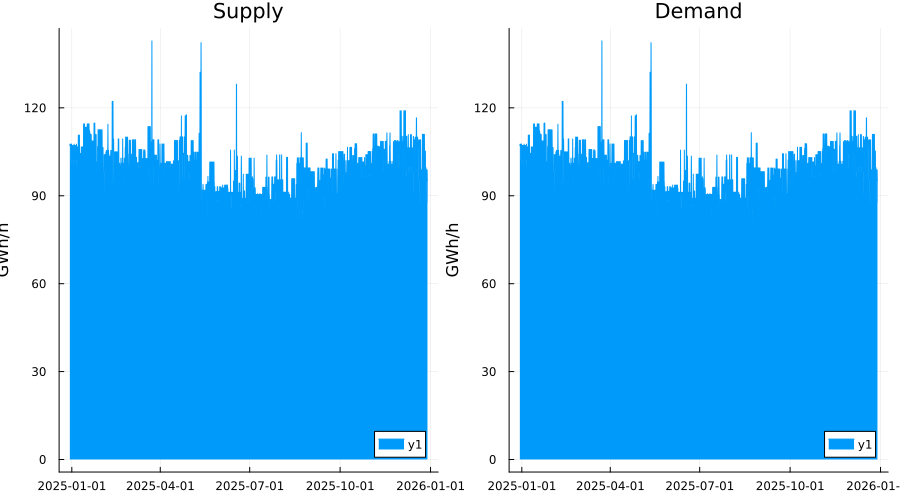

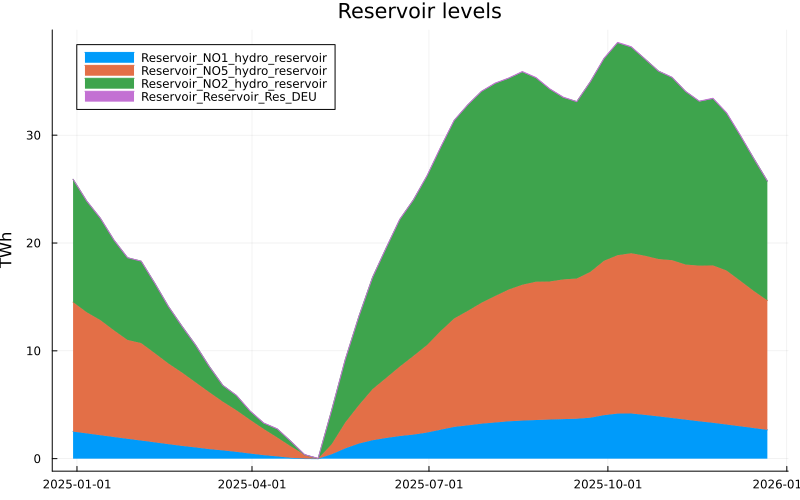

1×2 DataFrame
 Row │ Yearly_supply_TWh_sum_skipmissing  Yearly_demand_TWh_sum_skipmissing 
     │ Float64                            Float64                           
─────┼──────────────────────────────────────────────────────────────────────
   1 │                            861.32                             861.32

In [41]:
# Choose scenarios
scenarios = getscenarios(2025; years=1981:1981)

# Choose areas to see results from
resultobjects = getpowerobjects(modelobjects,["NOS","DMK","DEU"]) #,"NOS","DMK","DEU", "FRACHE"

runscenarios(scenarios, modelobjects, resultobjects)

### Change power horizon to be with daily resolution
Still the same amount of periods as the adaptive horizon, but the price has a lot less volatility now.

  0.164393 seconds (947.06 k allocations: 79.249 MiB)
  0.277051 seconds (2.90 M allocations: 102.838 MiB)
  1.018562 seconds
Objective value in scenario 1: 533629.4950254359


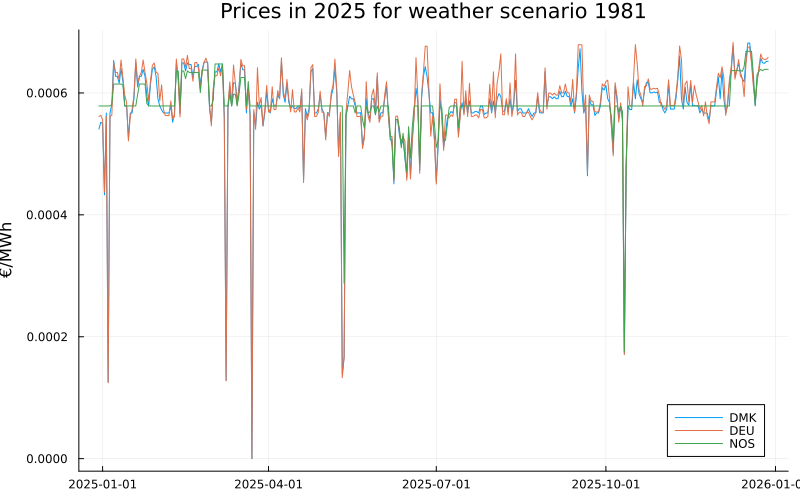

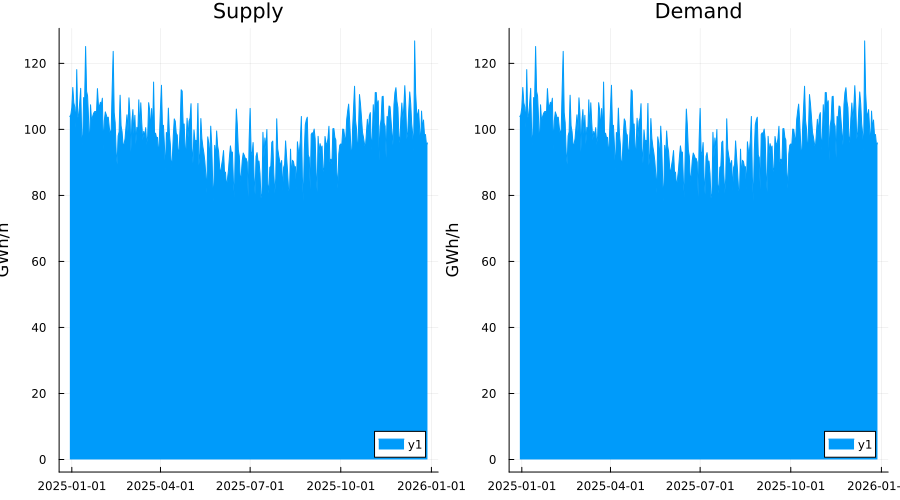

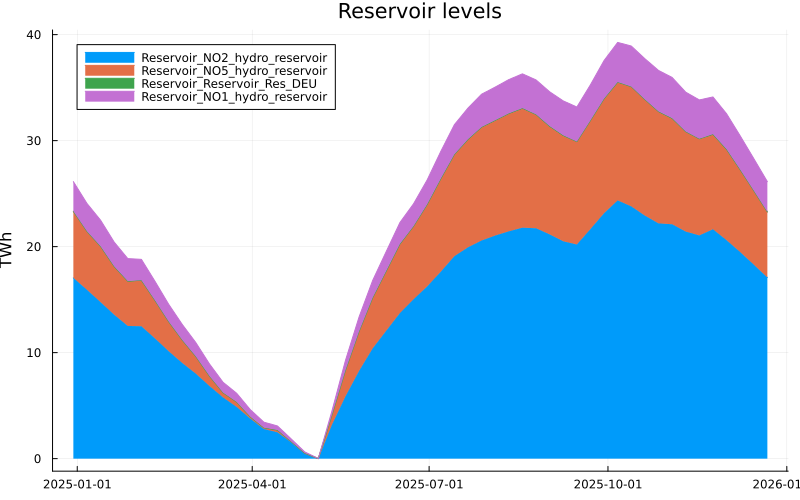

1×2 DataFrame
 Row │ Yearly_supply_TWh_sum_skipmissing  Yearly_demand_TWh_sum_skipmissing 
     │ Float64                            Float64                           
─────┼──────────────────────────────────────────────────────────────────────
   1 │                             859.1                              859.1

In [42]:
# Function to change power_horizon in elements list and make list of modelobjects
function get_modelobjects!(elements, new_power_horizon, new_hydro_horizon=nothing)
    
    # Change power_horizon in elements list
    set_horizon!(elements, "Power", new_power_horizon)
    set_horizon!(elements, "Battery", new_power_horizon)
    
    # Set new power_horizon to the global variable
    global power_horizon = new_power_horizon
    
    # If hydro horizon is changed
    if !isnothing(new_hydro_horizon)
        set_horizon!(elements, "Hydro", new_hydro_horizon)
        global hydro_horizon = new_hydro_horizon
    end

    # Create modelobjects and manipulate
    modelobjects = getmodelobjects(elements)
    simplify!(modelobjects)
    
    return modelobjects
end

power_horizon = SequentialHorizon(52*7, Day(1))
modelobjects = get_modelobjects!(elements, power_horizon)

# Choose areas to see results from
resultobjects = getpowerobjects(modelobjects,["DEU","DMK","NOS"]) #,"NOS","DMK","DEU", "FRACHE"

runscenarios(scenarios, modelobjects, resultobjects);

### Test time use detailed problem

  1.481904 seconds (3.75 M allocations: 373.401 MiB, 33.91% gc time)
  0.168774 seconds (2.13 M allocations: 64.929 MiB)
 18.780121 seconds
Objective value in scenario 1: 23582.497086455685


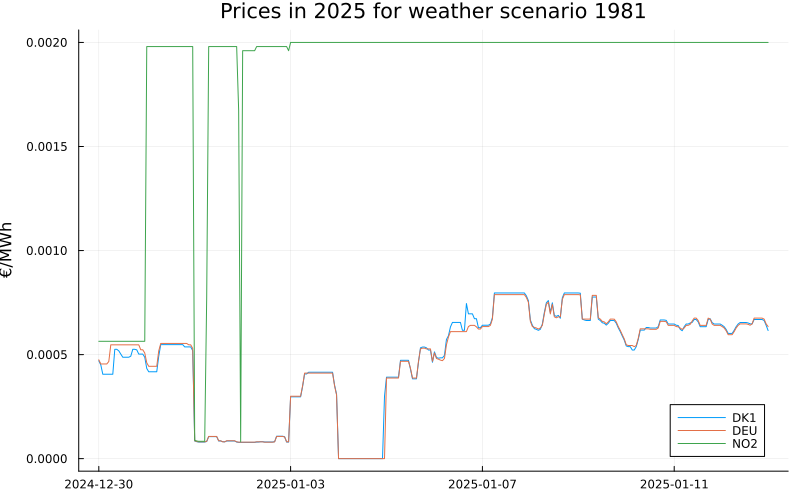

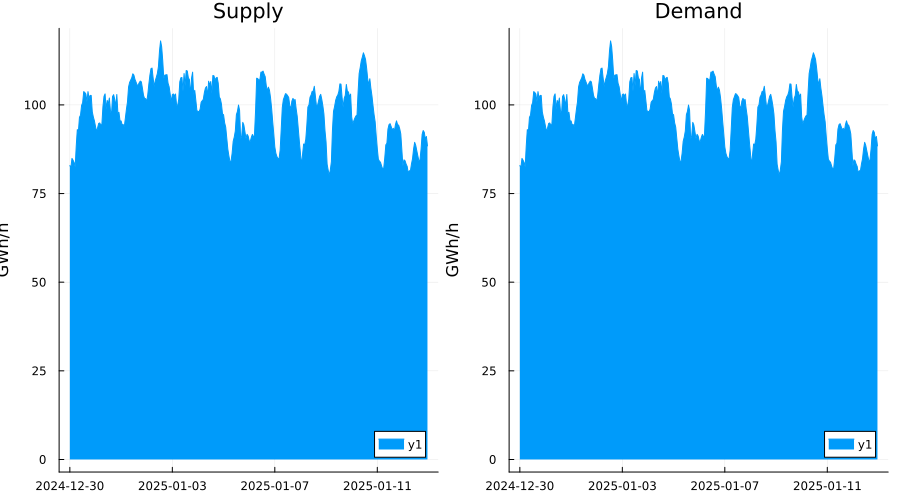

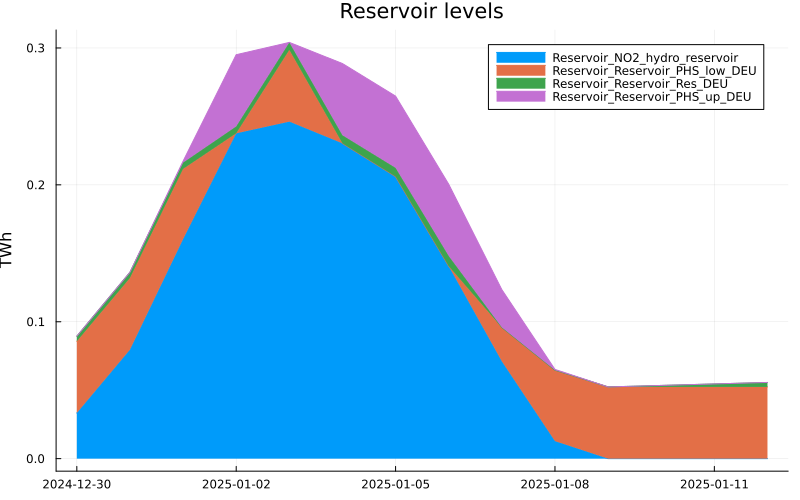

1×2 DataFrame
 Row │ Yearly_supply_TWh_sum_skipmissing  Yearly_demand_TWh_sum_skipmissing 
     │ Float64                            Float64                           
─────┼──────────────────────────────────────────────────────────────────────
   1 │                             861.2                              861.2

In [43]:
# Function to change power_horizon in elements list and make list of modelobjects
function get_detailed_modelobjects!(elements, new_power_horizon, new_hydro_horizon)
    
    # Change power_horizon in elements list
    set_horizon!(elements, "Hydro", new_hydro_horizon)
    set_horizon!(elements, "Power", new_power_horizon)
    set_horizon!(elements, "Battery", new_power_horizon)
    
    # Set new power_horizon to the global variable
    global hydro_horizon = new_hydro_horizon
    global power_horizon = new_power_horizon

    # Create modelobjects and manipulate
    modelobjects = getmodelobjects(elements)

    # Add slack variable for excessive renewable power
    addPowerUpperSlack!(modelobjects)

    # Storages have state-dependant variables that need a boundary conditions
    # We set the starting storage to be equal to the ending storage, x[0] = x[T] (for horizon where t in 1:T)
    addStartEqualStopAllStorages!(modelobjects)
    
    return modelobjects
end

hydro_horizon = SequentialHorizon(14, Day(1))
power_horizon = SequentialHorizon(14*24, Hour(1))
modelobjects = get_detailed_modelobjects!(elements, power_horizon, hydro_horizon)

# Choose areas to see results from
resultobjects = getpowerobjects(modelobjects,["DEU","DK1","NO2"]) #,"NOS","DMK","DEU", "FRACHE"

runscenarios(scenarios, modelobjects, resultobjects);

## 1.4 - Compare time usage with Adaptive vs Sequential horizon

Sequential daily is fastest since it updates the problem with time-series data for daily periods.

Sequential hourly is slowest since it updates the problem with time-series data for hourly periods. It would give the best prices, but at the the cost of being too slow. 

Adaptive takes a bit more time to update than sequential daily since we read and cluster hourly time-series data into seven periods per week. However the solvetime is similar to Sequential daily. This shows that Adaptive could be a good compromise between quality and speed.

In [44]:
function time_usage_horizon(modelobject, scenarios)
    
    @time prob = HiGHS_Prob(collect(values(modelobjects)))
    
    for (s, t) in enumerate(scenarios)
        @time update!(prob, t)
        
        @time solve!(prob)
    end
end

new_hydro_horizon = SequentialHorizon(52, Hour(168))

display("Sequential daily")
new_power_horizon = SequentialHorizon(52*7, Day(1))
modelobjects = get_modelobjects!(elements, new_power_horizon, new_hydro_horizon)
time_usage_horizon(modelobjects, scenarios)

display("Sequential hourly")
new_power_horizon = SequentialHorizon(52*7*24, Hour(1))
modelobjects = get_modelobjects!(elements, new_power_horizon)
time_usage_horizon(modelobjects, scenarios)

display("Adaptive cluster hours into 7 periods per week")
new_power_horizon = AdaptiveHorizon(clusters, unit_duration, DynamicRHSAHData("Power"), KMeansAHMethod(), 52, Hour(168))
modelobjects = get_modelobjects!(elements, new_power_horizon)
time_usage_horizon(modelobjects, scenarios)

"Sequential daily"

  0.160688 seconds (947.06 k allocations: 79.249 MiB)
  0.259810 seconds (2.90 M allocations: 102.838 MiB)
  1.000594 seconds


"Sequential hourly"

  5.399391 seconds (30.01 M allocations: 1.912 GiB, 14.78% gc time)
  8.069650 seconds (81.54 M allocations: 2.538 GiB, 18.74% gc time)
 82.525822 seconds


"Adaptive cluster hours into 7 periods per week"

  0.157925 seconds (784.13 k allocations: 74.089 MiB)
  0.527565 seconds (4.33 M allocations: 147.513 MiB)
  0.989712 seconds


##  1.5 - Compare time usage of HiGHS_Prob with JuMP_Prob
We made HiGHS_Prob because HiGHS was the fastest open-source solver possible to use with JuMP, but was very slow to update the problem in the JuMP implementation. We therefore implemented HiGHS_Prob directly on the HiGHS package. (Some new PRs has partly solved this problem, but HiGHS_Prob is still noticeably faster.)

We time building, updating and solving the problem for different Probs and solvers, to see the difference. This is of course only a small problem, and solving times could be improved by choosing other solver settings.

In [45]:
function time_usage_probs(modelobjects, scenarios, opt)
    if opt == "H"
        display("HiGHS_Prob")
        @time prob = HiGHS_Prob(collect(values(modelobjects)))
    elseif opt == "JC"
        display("JuMP_Prob w Clp")
        model = Model(Clp.Optimizer)
        set_silent(model)
        @time prob = JuMP_Prob(collect(values(modelobjects)), model)
    elseif opt == "JH"
        display("JuMP_Prob w HiGHS")
        model = Model(HiGHS.Optimizer)
        set_silent(model)
        @time prob = JuMP_Prob(collect(values(modelobjects)), model)
    end
    
    for (s, t) in enumerate(scenarios)
        @time update!(prob, t)
        
        @time solve!(prob)
    end
end

time_usage_probs(modelobjects, scenarios, "H")
time_usage_probs(modelobjects, scenarios, "JH")
time_usage_probs(modelobjects, scenarios, "JC")

"HiGHS_Prob"

  0.152025 seconds (784.13 k allocations: 74.089 MiB)
  0.525929 seconds (4.33 M allocations: 147.513 MiB)
  0.992669 seconds


"JuMP_Prob w HiGHS"

  0.294896 seconds (2.69 M allocations: 109.989 MiB)
  0.949522 seconds (5.25 M allocations: 167.560 MiB)
  1.540794 seconds (328.67 k allocations: 68.696 MiB)


"JuMP_Prob w Clp"

  0.297641 seconds (2.69 M allocations: 109.989 MiB)
  3.676010 seconds (5.25 M allocations: 167.560 MiB, 71.15% gc time)
  2.633417 seconds (206.80 k allocations: 97.849 MiB)


The results show that HiGHS_Prob is fastest for building, updating and solving the problem. This is because it is custom-built for our purpose. The higher time usage of JuMP_Prob w HiGHS actually comes from transferring the JuMP model into HiGHS rather that solving the problem with HiGHS.

We also see that HiGHS_Prob takes more time updating the problem than solving it. This could be improved by using the time-series more efficiently (now querying from time-series is coded very generic). Some possible improvements:
- If data points have constant distance between them, we can make a more efficient getweightedaverage that takes advantage of this
- Many objects can get data from the same time-series. Instead of the same calculations being done several times, we could store the results in an intermediate storage
- We could store the index of the previous time-series query, to quicker look up the next value

##  1.6 - Compare time usage with Simplex vs IPM

We compare time usage of HiGHS_Prob and JuMP_Prob with Clp, for different solver implementations: dual simplex and interior-point method (IPM). The result shows that HiGHS_Prob with dual simplex is fastest for this specific problem given the default solver settings. With other setting or a different problem (longer horizon / higher resolution / more objects), other combinations could be the fastest.

Overview of solver settings for Clp and HiGHS.
- https://github.com/jump-dev/Clp.jl
- https://github.com/jump-dev/HiGHS.jl

In [46]:
function time_usage_solver(modelobjects, scenarios, opt)
    if opt == "HS"
        display("HiGHS_Prob dual simplex")
        @time prob = HiGHS_Prob(collect(values(modelobjects)))
        Highs_setStringOptionValue(prob, "solver", "simplex")
    elseif opt == "HI"
        display("HiGHS_Prob ipm")
        @time prob = HiGHS_Prob(collect(values(modelobjects)))
        Highs_setStringOptionValue(prob, "solver", "ipm")
    elseif opt == "JCS"
        display("JuMP_Prob w Clp dual simplex")
        model = Model(Clp.Optimizer)
        set_optimizer_attribute(model, "SolveType", 0)
        set_silent(model)
        @time prob = JuMP_Prob(collect(values(modelobjects)), model)
    elseif opt == "JCI"
        display("JuMP_Prob w Clp ipm")
        model = Model(Clp.Optimizer)
        set_optimizer_attribute(model, "SolveType", 4)
        set_silent(model)
        @time prob = JuMP_Prob(collect(values(modelobjects)), model)
    end
    
    for (s, t) in enumerate(scenarios)
        @time update!(prob, t)
        
        @time solve!(prob)
    end
end

time_usage_solver(modelobjects, scenarios, "HS")
time_usage_solver(modelobjects, scenarios, "HI")
time_usage_solver(modelobjects, scenarios, "JCS")
time_usage_solver(modelobjects, scenarios, "JCI")

"HiGHS_Prob dual simplex"

  0.147051 seconds (784.13 k allocations: 74.089 MiB)
  0.483412 seconds (4.33 M allocations: 147.513 MiB)
  1.005430 seconds


"HiGHS_Prob ipm"

  0.150638 seconds (784.13 k allocations: 74.089 MiB)
  0.484490 seconds (4.33 M allocations: 147.513 MiB)
  4.141556 seconds


"JuMP_Prob w Clp dual simplex"

  0.279902 seconds (2.69 M allocations: 109.989 MiB)
  0.952369 seconds (5.25 M allocations: 167.560 MiB)
  2.621337 seconds (206.81 k allocations: 97.850 MiB)


"JuMP_Prob w Clp ipm"

  0.292119 seconds (2.69 M allocations: 109.989 MiB)
  0.955976 seconds (5.25 M allocations: 167.560 MiB)
  2.120379 seconds (206.81 k allocations: 97.850 MiB)


## 1.7 - Generate price-series for hydropower scheduling
In demo 4 we need an exogen price to optimize a watercourse against. We generate a 15 year price series for Denmark using the model year 2025 and the weather scenarios 1981-1995.

  0.680179 seconds (3.78 M allocations: 301.227 MiB)
 12.185991 seconds (77.09 M allocations: 1.832 GiB, 10.24% gc time)
  6.778113 seconds


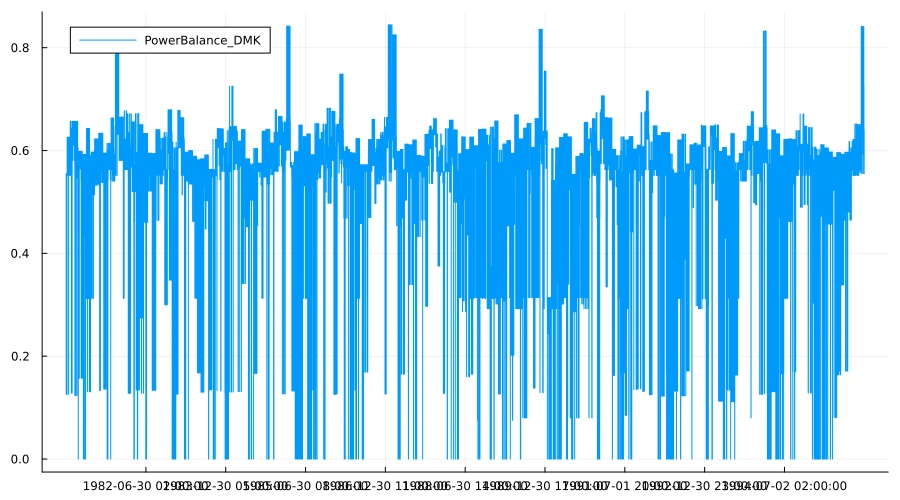

In [47]:
function make_price_series(elements)
    
    # Horizons can also be made from a starting and ending DateTime, and the duration D of the periods.
    # This will generate a horizon of N periods of duration D, and the last period will be the remaining duration (which is smaller than D)
    weeks = 4
    hydro_horizon = SequentialHorizon(getisoyearstart(1981), getisoyearstart(1996), Week(weeks))
    power_horizon = AdaptiveHorizon(7, Hour(1), DynamicRHSAHData("Power"), KMeansAHMethod(), getisoyearstart(1981), getisoyearstart(1996), Week(weeks))

    set_horizon!(elements, "Power", power_horizon)
    set_horizon!(elements, "Battery", power_horizon)
    set_horizon!(elements, "Hydro", hydro_horizon)

    modelobjects = getmodelobjects(elements)
    simplify!(modelobjects)
    
    @time prob = HiGHS_Prob(collect(values(modelobjects)))
    
    datayear = getisoyearstart(2025)
    scenarioyear = getisoyearstart(1981)
    t = FixedDataTwoTime(datayear, scenarioyear)
    @time update!(prob, t)
    @time solve!(prob)

    # We query the price from Denmark (since NOS price is too flat)
    id = Id(BALANCE_CONCEPT, "PowerBalance_DMK")
    balance = modelobjects[id]
    horizon = gethorizon(balance)
    
    # Generate and store price param as elements
    _values = -[getcondual(prob, id, s) for s in 1:getnumperiods(horizon)]
    generate_param(_values, scenarioyear, horizon, id)
end

# Function to generate and store price param as elements
function generate_param(values::Vector{Float64}, dt::DateTime, horizon::AdaptiveHorizon, id::Id)
    
    # Distribute values in AdaptiveHorizon periods to hours that represents the clusters
    points = []
    for t in 1:getnumperiods(horizon)
        value = values[t]
        timedelta = gettimedelta(horizon, t)
        startduration = getstartduration(horizon, t)
        for unit_range in timedelta.units
            for i in unit_range
                point_dt = dt + startduration + ((i-1) * timedelta.unit_duration)
                point = (point_dt, value)
                push!(points, point)
            end
        end
    end
    sort!(points)
    _index = [Dates.format(p[1], "yyyy-mm-dd HH:MM:SS") for p in points] # TODO: Change to Dates default format?
    _values = [p[2] for p in points]

    # Plot
    display(plot(_index, _values, label=getinstancename(id), size=(900,500)))
    
    # Store in dataelements
    e = []
    push!(e, (TIMEINDEX_CONCEPT,"VectorTimeIndex","IndexPriceDMK",
                    ("Vector",_index)))
    push!(e, (TIMEVALUES_CONCEPT,"VectorTimeValues","ValuesPriceDMK",
                    ("Vector",_values)))
    push!(e, (TIMEVECTOR_CONCEPT,"RotatingTimeVector","ProfilePriceDMK",
                    (TIMEINDEX_CONCEPT,"IndexPriceDMK"),(TIMEVALUES_CONCEPT,"ValuesPriceDMK")))
    push!(e, (PARAM_CONCEPT,"MeanSeriesParam","PriceDMK",
          ("Level",1),
          ("Profile","ProfilePriceDMK")))    

    open("priceDMK.json","w") do f
        JSON.print(f, e)
    end
end

make_price_series(elements)